# Imports

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# from tensorboardX import SummaryWriter
# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange

# writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print('GPU available? {}'.format(torch.cuda.is_available()))

GPU available? False


# Generate dataset

In [3]:
def toy_function(N):
    
    noise_std = 0.02
    eps_train = noise_std*np.random.randn(N,)
    eps_test =  noise_std*np.random.randn(int(N*0.5),)
    
    
    x_train = np.linspace(0, 0.5, N, endpoint=True, dtype =np.float32)
    x_test =  np.linspace(-1, 1, int(N*0.5), endpoint=True, dtype =np.float32)
    
    y_train = x_train + 0.3*np.sin(2*np.pi*(x_train + eps_train)) + 0.3*np.sin(4*np.pi*(x_train + eps_train)) + eps_train
    y_test =  x_test + 0.3*np.sin(2*np.pi*(x_test + eps_test)) + 0.3*np.sin(4*np.pi*(x_test + eps_test)) + eps_test
    
    x_train = np.atleast_2d(x_train).T
    x_test = np.atleast_2d(x_test).T
    
    x_train_tensor = torch.Tensor(x_train)
    y_train_tensor = torch.Tensor(y_train)
    x_test_tensor =  torch.Tensor(x_test)
    y_test_tensor =  torch.Tensor(y_test)
    
    plt.plot(x_train, y_train, 'rs', label='train')
    plt.plot(x_test, y_test, 'k.', label='test')
    plt.legend()
    plt.show()

    return x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor

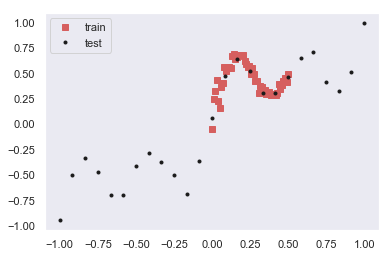

In [4]:
x_train, y_train, x_test, y_test = toy_function(50)

# Bayes-by-Backprop

In [5]:
from BBB_SMPP import MLP_BBB

prior_pi = 0.5
prior_sigma1 = 1 
prior_sigma2 = 10
net = MLP_BBB(1, 1, [5, 5], prior_pi, prior_sigma1, prior_sigma2, noise_tol=0.02)

net.to(DEVICE)
net.train()

data = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
target = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=1e-2)
epochs = 5000

loss_arr = list()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(data, target, 1)
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())

print('Finished Training')

plt.plot(loss_arr)
# plt.yscale('log')
plt.title('Loss during training')
plt.show()

/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
  0%|          | 1/5000 [00:00<08:40,  9.61it/s]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

net.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = net(data_ts).detach().numpy().ravel()
    post_dist[:, n_post_samples] = net(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Train points')
plt.plot(x_test.numpy(), y_test.numpy(), 'ro', label='Test points')
plt.plot(x_test.numpy(), y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test.numpy(), x_test.numpy()[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()

In [ ]:
t0 = torch.tensor([1,2,3,4,5])
t1 = torch.tensor([1,2,3,4,5])

# t0.unsqueeze_(-1)
# t1.unsqueeze_(-1)
# t2 = torch.cat((t0, t1), 1)
# print(t2)

In [ ]:
t0.view(-1, 1).shape

In [ ]:
t0 = torch.randn(3,)
t1 = torch.randn(3,)
t2 = torch.stack((t0, t1), dim=2).squeeze_()
t2.shape

In [ ]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

nnet.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = nnet(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train, y_train, 'k*', label='Train points')
plt.plot(x_test, y_test, 'ro', label='Test points')
plt.plot(x_test, y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()